**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn < 0.18 use:
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split


%matplotlib inline

In [2]:
def imread(file):
    img = cv2.imread(file)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
# Read in all the images for vehicle and non vehicle in the data set

vehicles = glob.glob('vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('non-vehicles/**/*.png', recursive=True)

print("found vehicles count:", len(vehicles))
print("found non-vehicles count:", len(non_vehicles))

found vehicles count: 8792
found non-vehicles count: 8968


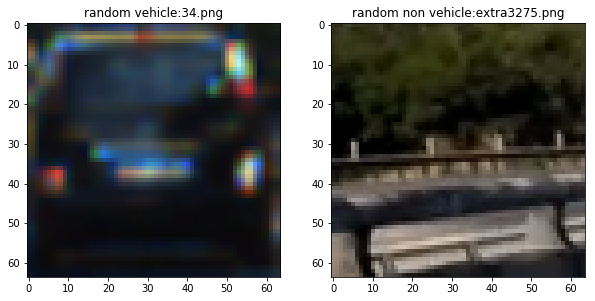

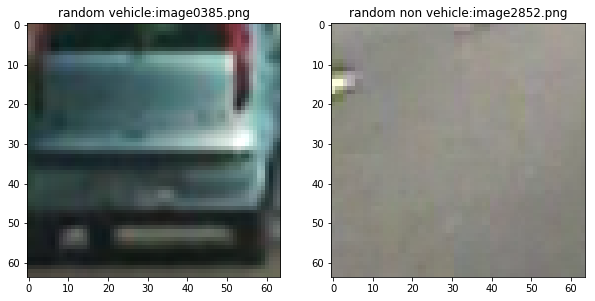

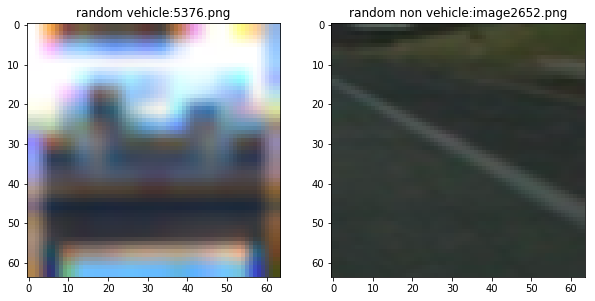

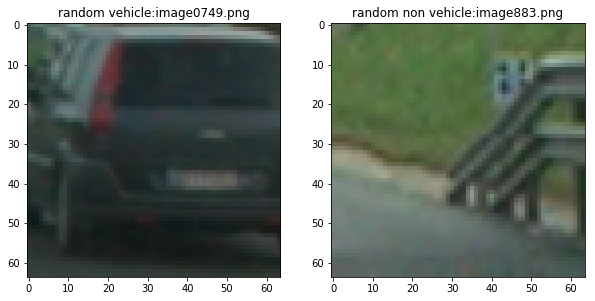

In [4]:
# display a vehicle and a non vehicle image

example_count = 4
random_vehicle = np.random.choice(vehicles, example_count)
random_non_vehicle = np.random.choice(non_vehicles, example_count)

for idx in range(example_count):
    random_vehicle_img = imread(random_vehicle[idx])
    random_non_vehicle_img = imread(random_non_vehicle[idx])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(random_vehicle_img)
    ax1.set_title('random vehicle:' + os.path.basename(random_vehicle[idx]))
    ax2.imshow(random_non_vehicle_img)
    ax2.set_title('random non vehicle:' + os.path.basename(random_non_vehicle[idx]))

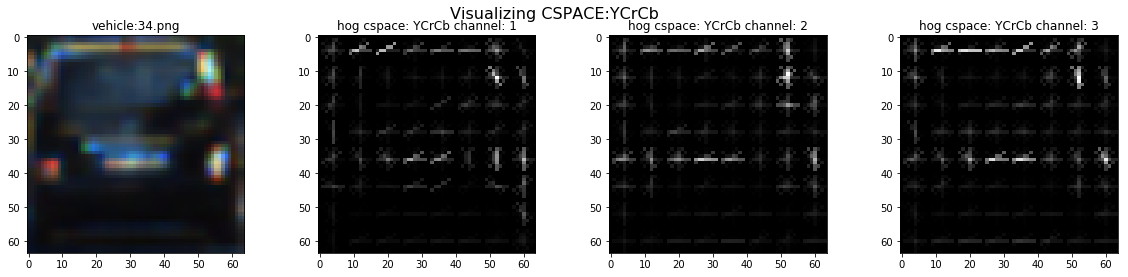

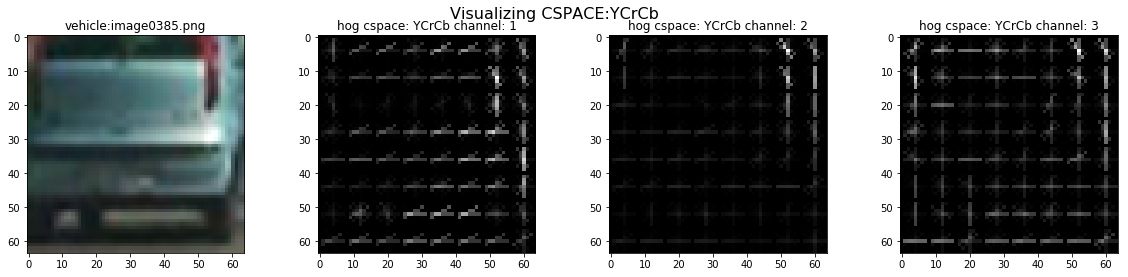

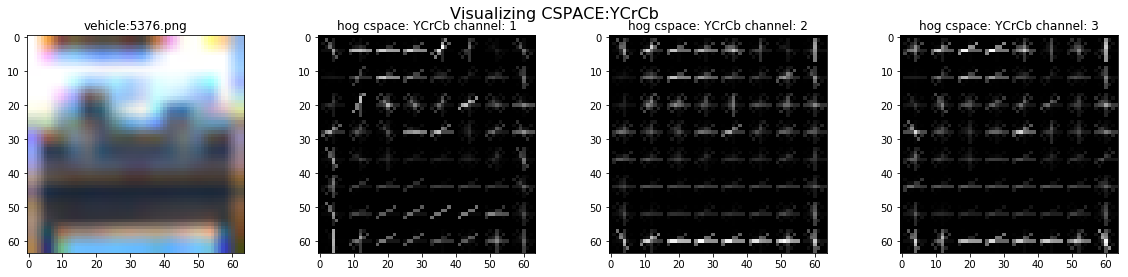

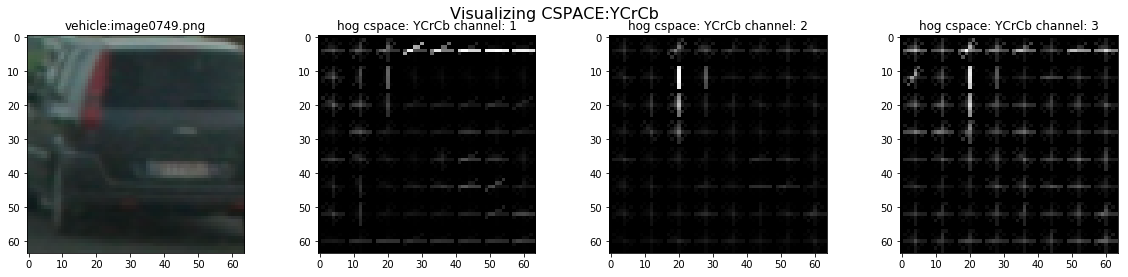

In [5]:
hog_only = False
# extract HOG and visualize
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm = "L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm = "L2-Hys")
        return features, None

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features_from_image(image, cspace='YUV', orient=8, 
                        pix_per_cell=8, cell_per_block=1, hog_channel="All", 
                        spatial_size = (32, 32), hist_bins = 32, hist_range = (0, 256),vis=False):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    hog_images = []
    if hog_channel.upper() == 'ALL':
        hog_features = []        
        for channel in range(feature_image.shape[2]):
            channel_features, channel_hog_image = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=vis, feature_vec=True)
            hog_features.append(channel_features)
            if vis == True:
                hog_images.append(channel_hog_image)
            
        hog_features = np.ravel(hog_features)
        
    elif hog_channel < 3:
        hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
        if vis == True:
            hog_images.append(hog_image)
    else:
        raise "Invalid hog channel"
        
    if hog_only :
        return hog_features, hog_images
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_features, hist_features, hog_features))
    
    # Return list of feature vectors
    return features, hog_images

def extract_features(image_files, cspace='YUV', orient=6, pix_per_cell=8, cell_per_block=1,
                     hog_channel="All"):
    features = []
    for file in image_files:
        img = imread(file)
        img_hog, dummy  = extract_features_from_image(img, cspace=cspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel= hog_channel,vis=False)
        features.append(img_hog)
    
    return features
        
def visualizeHog(cspace='YUV', orient=6, pix_per_cell=8, cell_per_block=1):
    for idx in range(example_count):
        random_vehicle_img = imread(random_vehicle[idx])
        features, hog_imgs = extract_features_from_image(random_vehicle_img, cspace=cspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True)
        fig, axs = plt.subplots(1, len(hog_imgs) + 1, figsize=(20,4))
        axs = np.array(axs)
        axs = axs.reshape(-1)
        axs[0].imshow(random_vehicle_img)
        axs[0].set_title('vehicle:' + os.path.basename(random_vehicle[idx]))    
        for idx in range(1,len(axs)):
            axs[idx].imshow(hog_imgs[idx - 1], cmap='gray')
            axs[idx].set_title("hog cspace: %s channel: %d" %(cspace, idx))
        fig.suptitle("Visualizing CSPACE:"+ cspace, fontsize=16)

cspaces = ['YCrCb']
## Visualize Different settings -- uncomment line below to view all spaces
#cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

for cspace in cspaces:
    visualizeHog(cspace=cspace)

# Generate the classification Data


In [6]:
def train():
    cspace = 'YCrCb'
    orient = 8
    pix_per_cell = 8
    cell_per_block = 1
    hog_channel="All"
    
    t=time.time()
    vehicle_features = extract_features(vehicles, cspace=cspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel)
        
    non_vehicle_features = extract_features(non_vehicles, cspace=cspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel)
    
    vehicle_features = np.array(vehicle_features)
    vehicle_features = np.array(vehicle_features)
    t2 = time.time()
    
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc, X_scaler

def train_save(save = False):    
    if not save:
        return 
    svc, X_scaler = train()
    model = {
        "clf": svc,
        "X_scaler" : X_scaler,
    }
    with open("model.p", "wb") as fp:
        pickle.dump(model, fp, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved the new model!")

# Train and save the classifier
# Change to true if you want to save the new model and overwrite the current one. 
train_save(save = False)

96.6 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 4704
12.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.0 Seconds to predict 10 labels with SVC
Saved the new model!


In [7]:
# Now load the model so we can move forward.
def train_load():
    with open("model.p", "rb") as fp:
        model = pickle.load(fp)
    return model["clf"], model["X_scaler"]
        
svc, X_scaler = train_load()

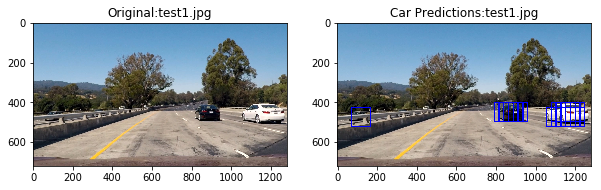

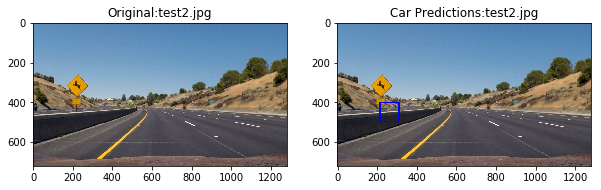

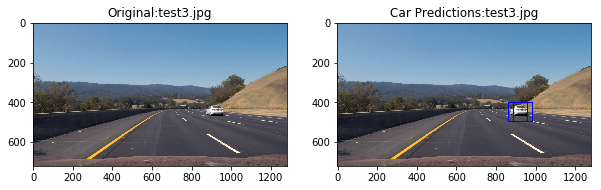

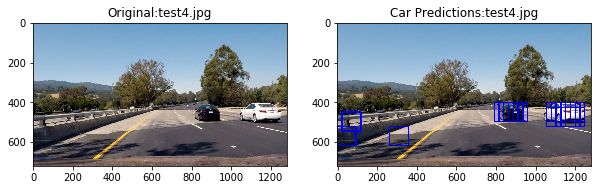

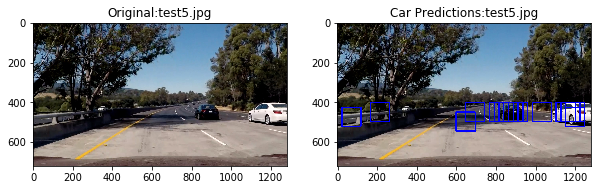

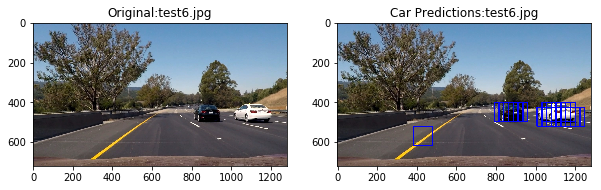

In [8]:
#Find cars on the image

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart = 400, ystop = 656, scale = 1.5, orient=8, 
                        pix_per_cell=8, cell_per_block=1, spatial_size = (32, 32), hist_bins = 32):
    
        
    img_tosearch = img[ystart:ystop,:,:]
    
    #ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1, dummy = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2, dummy  = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3, dummy  = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if hog_only :
                test_features = hog_features
            else:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                test_features = np.concatenate((spatial_features, hist_features, hog_features))

            # Scale features and make a prediction
            
            test_features = np.vstack(test_features)
            test_features = X_scaler.transform(test_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw, ytop_draw+win_draw+ystart]])
                
    return boxes

test_images = glob.glob("test_images/*.jpg")

for file in test_images:
    test_img = imread(file)
    boxes = find_cars(test_img)
    cars_boxes_img = np.copy(test_img)
    for box in boxes:
        cv2.rectangle(cars_boxes_img,(box[0][0], box[0][1]),(box[1][0],box[1][1]),(0,0,255),6)                 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(test_img)
    ax1.set_title('Original:' + os.path.basename(file))
    ax2.imshow(cars_boxes_img)
    ax2.set_title('Car Predictions:' + os.path.basename(file))

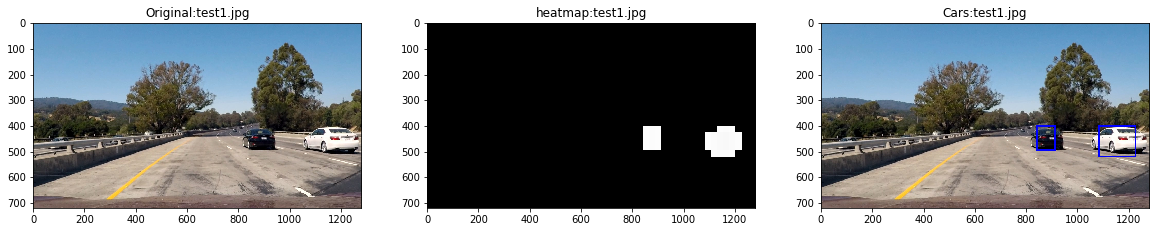

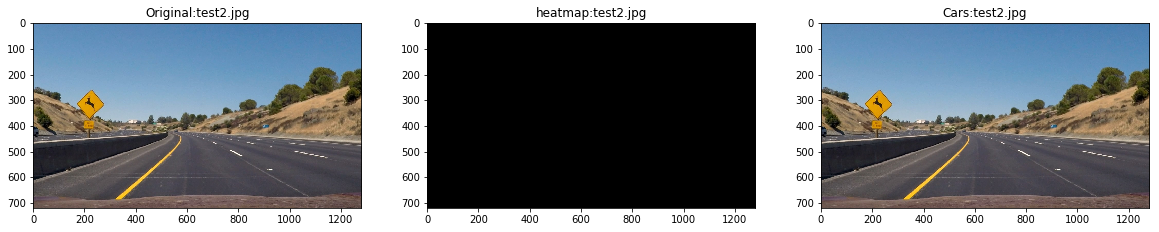

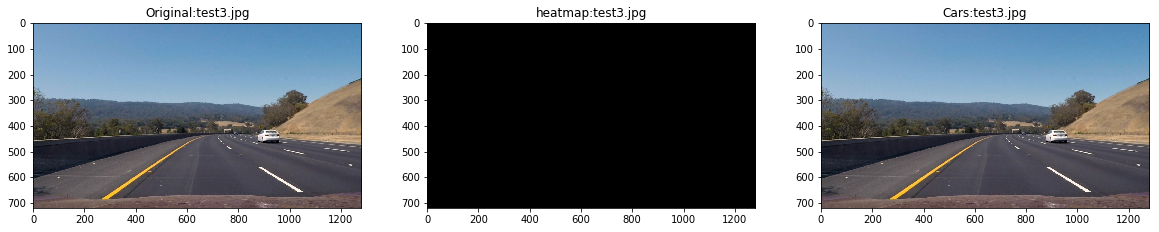

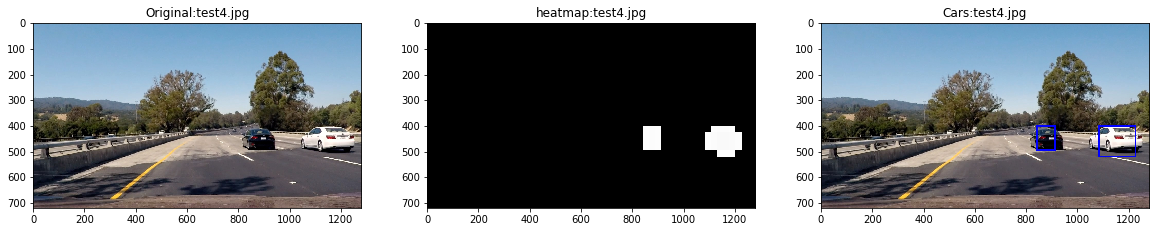

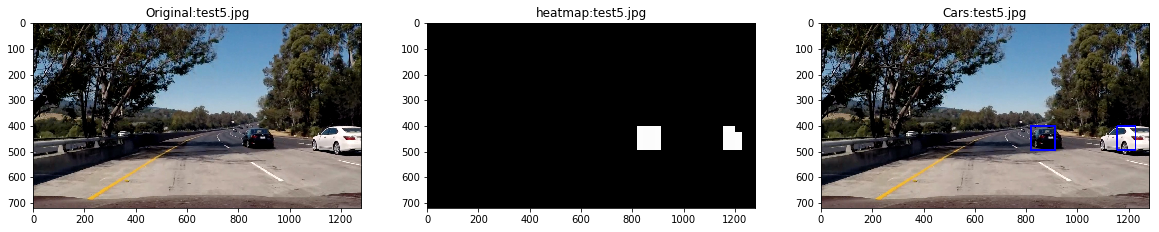

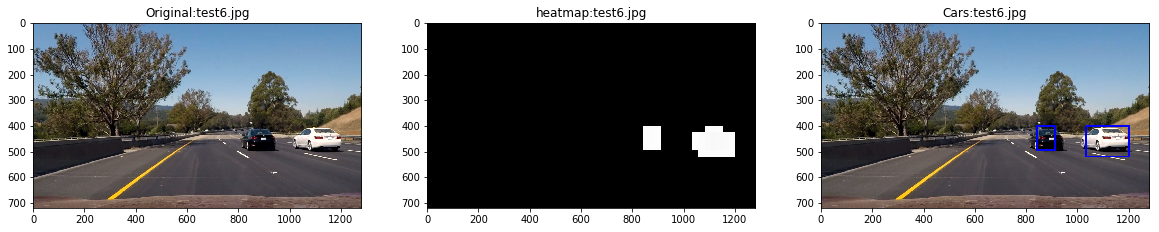

In [9]:
# We see a few false positives so lets apply a thresholded heatmap
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, boxes

for file in test_images:
    test_img = imread(file)
    boxes = find_cars(test_img)
    heat = np.zeros_like(test_img).astype(np.float)
    heat = add_heat(heat, boxes)
    heat = apply_threshold(heat, threshold=2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, dummy = draw_labeled_bboxes(np.copy(test_img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(test_img)
    ax1.set_title('Original:' + os.path.basename(file))
    ax2.imshow(heatmap, cmap="gray")
    ax2.set_title('heatmap:' + os.path.basename(file))
    ax3.imshow(draw_img)
    ax3.set_title('Cars:' + os.path.basename(file))

In [12]:
class pipeline():
    def __init__(self):
        self.cache_size = 10
        self.cache = []
        
    def heater(self, test_img, boxes):
        
        cached_boxes = []
        for c in self.cache:
            cached_boxes += c
        fboxes = boxes + cached_boxes
        heat = np.zeros_like(test_img).astype(np.float)      
        
        heat = add_heat(heat, fboxes)
        heat = apply_threshold(heat, threshold=15)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img, new_boxes = draw_labeled_bboxes(np.copy(test_img), labels)
        
        if new_boxes != None or new_boxes != []:
            self.cache += [boxes]
            
        if(len(self.cache) > self.cache_size):
            self.cache.pop(0)       
            
        return draw_img
    
    def process(self, img):
        boxes = find_cars(img, scale=1.5)
        return self.heater(img, boxes)
    
vid_pipeline = pipeline()

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'proccessed_project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")#.subclip(40,45)
project_clip = clip1.fl_image(vid_pipeline.process) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video proccessed_project_video.mp4
[MoviePy] Writing video proccessed_project_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:20:06<00:05,  5.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: proccessed_project_video.mp4 

Wall time: 2h 20min 7s
